<a href="https://colab.research.google.com/github/omanshuthapliyal/formationControl/blob/relativeMotionDescription/SupervisoryControlAttack_formation_of_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining ***Robot Formation*** model.

Adapted from [Hybrid Control of Formation of Robots](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=932546).



In [0]:
from numpy import matmul 
import numpy as np
from numpy import pi
import scipy.linalg
import matplotlib.pyplot as plt
from math import sin, cos, acos, atan, sqrt
import scipy.integrate as integrate

In [17]:
pi - atan(2/1.3)

2.14717154738608

## Plant Objects

In [0]:
def stateProp(xDot, x, t, dt):
  # xDot = dx/dt = constant during dT, x = x(t), dt = Delta T
  dx = xDot*dt
  return x + dx
  
class PLANT:
  def __init__(self):
    # See beginning of section 4
    self.d = 0.1  # Robot dimension
    self.l_des = [[0, 1, 1],
                  [1, 0, 1],
                  [1, 1, 0]]
    # See Eq. 19
    d12 = pi/2
    d13 = acos((self.l_des[0][1]**2 + self.l_des[0][2]**2 - self.l_des[1][2]**2)/
               (2*self.l_des[0][1]*self.l_des[0][2])) + d12
    d23 = pi + pi/6
    self.psi_des = [[0, d12, d13],
                    [d12, 0, d23],
                    [d13, d23, 0]]
    self.r = np.array([3, 3, 3]) # Sensor radius, unspecified in the paper
    self.t = 0
    self.dt = 0.01
    self.l = [[0, 1.5, sqrt(1.04)],
              [1.5, 0, sqrt(5.69)],
              [sqrt(1.04), sqrt(5.69), 0]]
    self.lDot = np.zeros_like(self.l)
    self.psi = [[0, -pi/6, -pi/6 + atan(10)],
                [-pi/6, 0, pi - atan(2/1.3)],
                [-pi/6 + atan(10), pi - atan(2/1.3), 0]]
    self.psiDot = np.zeros_like(self.psi)
    # Initial conditions in global coordinates
    self.x = np.array([0, 1.5, 0.2])
    self.y = np.array([0, 0, 2])
    self.xDot = np.zeros_like(self.x)
    self.yDot = np.zeros_like(self.x)
    self.theta = np.array([pi/6, 0, pi/6])
    self.thetaDot = np.zeros_like(self.theta)
    self.v = 0.5
    self.w = np.array([0.1*sin(0.2*self.t), 0, 0])
    self.k1 = 1
    self.k2 = 1
    self.k3 = 1

  def SB_ijC(self,i,j):
    # Robots j follows Robot i
    
    # Global coordinate equations from Eq 2-4
    gamma_ij = self.theta[i] - self.theta[j] + self.psi[i][j]
    s_ij = self.k1 * (self.l_des[i][j] - self.l[i][j])
    b_ij = self.k2 * (self.psi_des[i][j] - self.psi[i][j])
    # Eqs. 2-3
    self.v[j] = ( s_ij * cos(gamma_ij) - self.l[i][j] * sin(gamma_ij) * (b_ij + self.w[i]) + 
                 self.v[i]*cos(self.theta[i]-self.theta[j]) )
    self.w[j] = ( s_ij * sin(gamma_ij) + self.l[i][j] * cos(gamma_ij) * (b_ij + self.w[i]) + 
                 self.v[i]*sin(self.theta[i]-self.theta[j]) )/self.d

    # See Eqs. 15 - 17
    self.lDot[i][j] = s_ij
    self.l[i][j] = stateProp(self.lDot[i][j],
                             self.l[i][j], self.t, self.dt)
    
    self.psiDot[i][j] =
    self.psi[i][j] = stateProp(self.psiDot[i][j],
                             self.psi[i][j], self.t, self.dt)
    
    self.thetaDot[j] = self.w[j]
    self.theta[j] = stateProp(self.thetaDot[j],
                             self.theta[j], self.t, self.dt)
    


  def S_ikS_jkC(self,i,j,k):
    # Robot k follows Robots i & j
    # Global coordinate equations from Eqs 6-7
    gamma_jk = self.theta[j] - self.theta[k] + self.psi[j]][k]
    gamma_ik = self.theta[i] - self.theta[k] + self.psi[i]][k]

    s_ik = self.k1 * (self.l_des[i][k] - self.l[i][k])
    s_jk = self.k1 * (self.l_des[j][k] - self.l[j][k])

    
    
    # See Eq. 17
    self.lDot[i][k] = self.k1 * (self.l_des[i][k] - self.l[i][k])
    self.l[i][k] = stateProp(self.lDot[i][k],
                             self.l[i][k], self.t, self.dt)
    
    self.lDot[j][k] = self.k1 * (self.l_des[j][k] - self.l[j][k])
    self.l[j][k] = stateProp(self.lDot[j][k],
                             self.l[j][k], self.t, self.dt)
    
    self.thetaDot[k] = self.w[k]
    self.theta[k] = stateProp(self.thetaDot[k],
                             self.theta[k], self.t, self.dt)


  def autoNavig(self, i):
    self.xDot[i-1] = self.v*cos(self.theta[i-1])
    self.x[i-1] = stateProp(self.xDot[i-1], self.x[i-1], self.t, self.dt)

    self.yDot[i-1] = self.v*sin(self.theta[i-1])
    self.y[i-1] = stateProp(self.yDot[i-1], self.y[i-1], self.t, self.dt)

    self.thetaDot[i-1] = self.w[i-1]
    self.theta[i-1] = stateProp(self.thetaDot[i-1], self.theta[i-1], self.t, self.dt)
    
  def updatePosition(self, i):
    # Update the position of robot i following robot 1
    # Updates using position of Robot 1
    self.x[i] = self.x[0] + self.l[0][i]*cos(self.psi[0][i]+self.theta[0])
    self.y[i] = self.y[0] + self.l[0][i]*sin(self.psi[0][i]+self.theta[0])

  def propagate(self, supervObj, i):
    # ID = 1, 2, 3 are robot numbers. We are interested in Robot 3
    if i == 1:
      # leader's dynamics are given by Eq. 1
      self.w[0] = 0.1*sin(0.2*self.t)
      self.thetaDot[i-1] = self.w[0]
      self.theta[i-1] = stateProp(self.thetaDot[i-1], self.theta[i-1], self.t, self.dt)

      self.xDot[i-1] = self.v*cos(self.theta[0])
      self.x[i-1] = stateProp(self.xDot[i-1], self.x[i-1], self.t, self.dt)

      self.yDot[i-1] = self.v*sin(self.theta[0])
      self.y[i-1] = stateProp(self.yDot[i-1], self.y[i-1], self.t, self.dt)
    
    elif i == 2:
      # Robot 2 is always in SB_12C mode,that is, following robot 1
      self.SB_ijC(0,1)    # (1,2) = (0,1) due to zero indexing
      self.updatePosition(i-1) 
    
    else:
      # Choose mode for Robot 3
      mode = supervObj.switch(self)
      if mode == 1: 
        self.SB_ijC(0,2)    # Robot 3 follows Robot 1
      elif mode == 2: 
        self.SB_ijC(1,2)    # Robot 3 follows Robot 2
      elif mode == 3: 
        self.S_ikS_jkC(0,2,1)    # Robot 3 follows Robot 1 & 2 
      elif mode == 4: # Autonomous Navigation for Robot 3
        print("Attempting AutoNav . . . define this function")
      # Update states for Robot 3 after updating the mode
      self.updatePosition(i-1) 
    

## Supervisor Model

In [0]:
 class supervisor:
    def switch(self, Plant):
    # Supervisory Logic for Robot 3, where it can detect robots 1 & 2
    # based on Section 3.1
      b1 = (Plant.l[0][2] < Plant.l[1][2]) and (Plant.l[1][2] > Plant.r[0]) and\
      (Plant.l[0][2] < Plant.r[1]) 
      b2 = (Plant.l[0][2] > Plant.l[1][2]) and (Plant.l[0][2] > Plant.r[0]) and\
      (Plant.l[1][2] < Plant.r[1]) 
      b3 = (Plant.l[0][2] < Plant.r[0]) and (Plant.l[1][2] < Plant.r[0])
      b4 = (Plant.l[0][2] > Plant.r[1]) and (Plant.l[1][2] > Plant.r[1])
      if b1 == True: return 1
      elif b2 == True: return 2
      elif b3 == True: return 3
      elif b4 == True: return 4

## Propagate plant to simulate supervisor
Not used in training, only to visualize plant behaviour

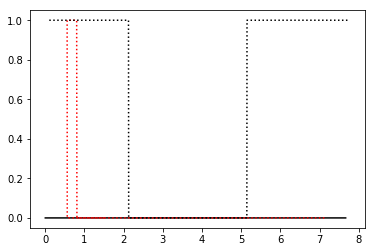

array([[0.00000000e+00, 1.50000000e+00, 1.01474281e-01],
       [4.33012702e-03, 1.49405333e+00, 1.05804408e-01],
       [8.66024904e-03, 1.48767261e+00, 1.10132501e-01],
       ...,
       [7.65869285e+00, 7.15868479e+00, 7.76015768e+00],
       [7.66302297e+00, 7.16301939e+00, 7.76449306e+00],
       [7.66735309e+00, 7.16735228e+00, 7.76882642e+00]])

In [113]:
# Initial parameters for running plant 
ROBOTS = PLANT()
tSim = 10*pi
SUPER = supervisor()
tHISTORY = np.zeros((int(tSim/ROBOTS.dt)+1,1))
xHISTORY = np.zeros((tHISTORY.size,3))
yHISTORY = np.zeros_like(xHISTORY)
thetaHISTORY = np.zeros_like(xHISTORY)

for t in range(tHISTORY.size):
# Looping across time
  for i in range(3):
    # Looping over robots
    xHISTORY[t][i] = ROBOTS.x[i]
    yHISTORY[t][i] = ROBOTS.y[i]
    thetaHISTORY[t][i] = ROBOTS.theta[i]
    ROBOTS.propagate(SUPER,i)
  ROBOTS.t += ROBOTS.dt

# Plotting trajectories:
colors = ['k-','r:','k:']
for i in range(3):
  plt.plot(xHISTORY[:,i],yHISTORY[:,i],colors[i])
plt.show()

10.1

# Building Statistical model of Supervisory logic

## Making Queries to the Supervisor object

In [0]:
#Import necessary packages
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras import backend as K

In [0]:
# Making Queries to the Supervisor
nDim = 4
nModes = 2
mean = np.zeros(nDim)
cov = np.eye(4)*100
nQ = 15000
# Collecting data from Queries
data = np.zeros((nQ, nDim))
labels = np.zeros(nQ)
ctr = 0
for i in range(nQ):
  data[i,:] = np.random.multivariate_normal(mean,cov)
  s = SUP.switch(data[i,:])
  if s == 1: 
    ctr+=1
    labels[i] = 1 
k = np.random.choice(nQ)
# Converting labels to one-hot-vectors
labels = keras.utils.np_utils.to_categorical(labels, num_classes=nModes)
# Splitting dataset
data_train = data[0:10000,:]
labels_train = labels[0:10000,:]
data_test = data[10000:,:]
labels_test = labels[10000:,:]

## Defining Neural Network Architecture

In [0]:
def NN_arch():
  model = Sequential()

  # Input Layer: accepts nDim number of inputs
  model.add(Dense(units = nDim, 
                  use_bias = True, 
                  kernel_initializer = "uniform"))
  # Second Layer with 3 units
  model.add(Dense(units = 3,
                  use_bias = True,
                  kernel_initializer = "uniform",
                  activation = "relu"))
  model.add(Dropout(0.30))
  '''
  # Third Layer with 6 units
  model.add(Dense(units = 6,
                  use_bias = True,
                  kernel_initializer = "uniform",
                  activation = "relu"))
  model.add(Dropout(0.30))
  '''
  # Output Layer with 2 units
  model.add(Dense(units = nModes,
                  activation = "sigmoid",
                  kernel_initializer = "uniform"))
  return model

## Training model

### Building Model

In [0]:
supervisorApprox = NN_arch()
supervisorApprox.build((None, nDim))
print(supervisorApprox.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_89 (Dense)             (None, 3)                 15        
_________________________________________________________________
dropout_6 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 8         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
None


### Training model

In [0]:
print(data_train.shape)
supervisorApprox.compile(loss="mean_squared_error", 
                    optimizer = "adam", 
                    metrics = ['accuracy'])
supervisorApprox_metaData = supervisorApprox.fit(
                data_train, labels_train, 
                validation_data = (data_test, labels_test), 
                epochs = 50, 
                batch_size = 100, 
                shuffle = True)
#Print accuracy of model on testing set after training 
scores = supervisorApprox.evaluate(data_test, labels_test)
print("Accuracy: %0.4f%%" %(scores[1]*100) )

(10000, 4)
Train on 10000 samples, validate on 5000 samples
Epoch 1/50
10000/10000 [==============================] - 2s 193us/step - loss: 0.2318 - acc: 0.9668 - val_loss: 0.1985 - val_acc: 0.9764
Epoch 2/50
10000/10000 [==============================] - 0s 18us/step - loss: 0.1608 - acc: 0.9790 - val_loss: 0.1282 - val_acc: 0.9764
Epoch 3/50
10000/10000 [==============================] - 0s 19us/step - loss: 0.1274 - acc: 0.9790 - val_loss: 0.1106 - val_acc: 0.9764
Epoch 4/50
10000/10000 [==============================] - 0s 19us/step - loss: 0.1134 - acc: 0.9790 - val_loss: 0.0994 - val_acc: 0.9764
Epoch 5/50
10000/10000 [==============================] - 0s 21us/step - loss: 0.1037 - acc: 0.9790 - val_loss: 0.0903 - val_acc: 0.9764
Epoch 6/50
10000/10000 [==============================] - 0s 19us/step - loss: 0.0944 - acc: 0.9790 - val_loss: 0.0824 - val_acc: 0.9764
Epoch 7/50
10000/10000 [==============================] - 0s 18us/step - loss: 0.0865 - acc: 0.9790 - val_loss: 0.075

### Model Performance Plots

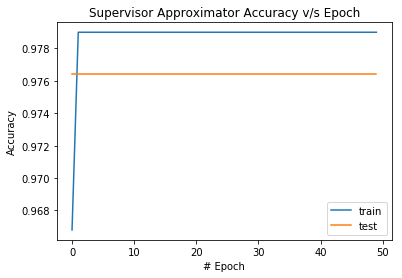

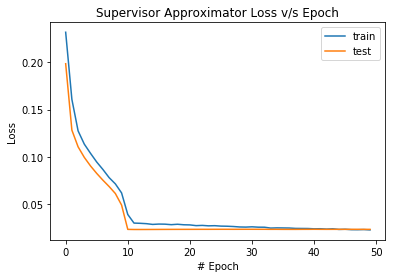

In [0]:
#Plot accuracy vs epoch
plt.plot(supervisorApprox_metaData.history['acc'])
plt.plot(supervisorApprox_metaData.history['val_acc'])
plt.title('Supervisor Approximator Accuracy v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

#Plot loss vs epoch
plt.plot(supervisorApprox_metaData.history['loss'])
plt.plot(supervisorApprox_metaData.history['val_loss'])
plt.title('Supervisor Approximator Loss v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

# Performing Attacks

## Gradient Calculation for Statistical model of Supervisory logic

In [0]:
grads = K.gradients(supervisorApprox.output, supervisorApprox.input)
sess = K.get_session()
xTest = data_train[1,:].reshape((1,4))
def evalGrad(xIn):
  G = sess.run(grads[0], 
                    feed_dict={supervisorApprox.input: xIn})
  return G

## Attacking some point ***x***
This is based on infinity norm attack, given by [ECE 559, Spring 2019 Lecture notes excerpts.](https://i.imgur.com/nycltSw.jpg)

See [this paper](https://arxiv.org/pdf/1602.02697.pdf) for further details.

In [0]:
def attacker(grads, xCurrent, pertMax, normCase):
# Inputs: 
# grads: gradient of trained model
# xCurrent: current point to be perturbed
# pertMax: maximum allowable perturbation, or maximum attack strength
    gradientCurrent = evalGrad(xCurrent)
    if normCase == 1:
      # For infinity norm attack
      perturbation = pertMax * np.sign(gradientCurrent)
    elif normCase == 2:
      # For L2 norm attack
      perturbation = pertMax * (gradientCurrent/np.linalg.norm(gradientCurrent, 2))
    return xPert

## Validating Attacker